

Este notebook realiza o treinamento de modelos de classificação e avalia a performance com métricas padrão.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             roc_curve, classification_report)
from imblearn.over_sampling import SMOTE
import joblib
import os


sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1, index_col=0)


print("Primeiras linhas do dataset:")
print(df.head())

print("\nInformações do dataset:")
print(df.info())

print("\nEstatísticas descritivas:")
print(df.describe())

print("\nValores faltantes por coluna:")
print(df.isnull().sum())

Primeiras linhas do dataset:
    LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   
3       90000    2          2         2   34      0      0      0      0   
4       50000    2          2         1   37      0      0      0      0   
5       50000    1          2         1   57     -1      0     -1      0   

    PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
ID         ...                                                                  
1      -2  ...          0          0          0         0       689         0   
2       0  ...       3272       3455       3261         0      1000      1000   
3       0  ...      14331      14948      15549      1518      1500      1000   
4       0  ...      28314      28

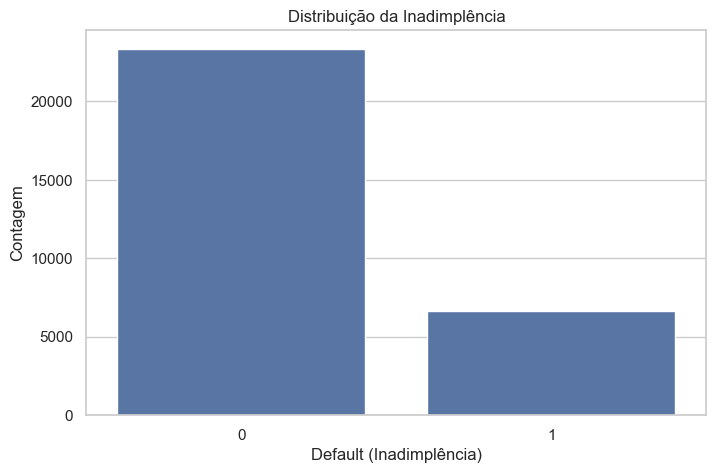

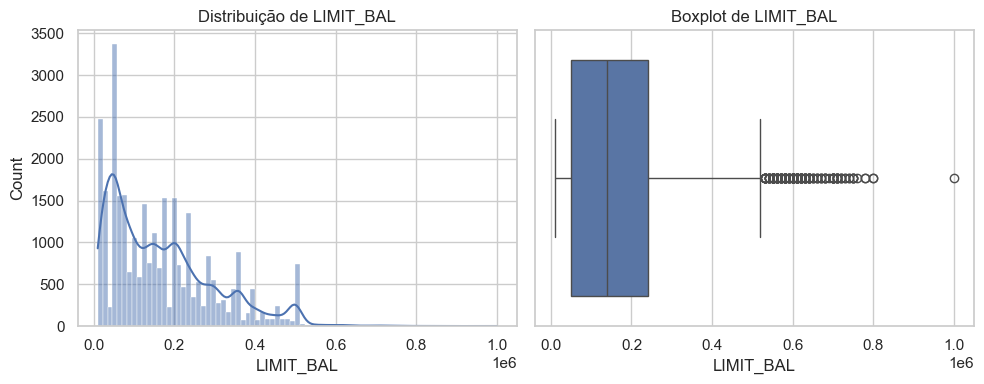

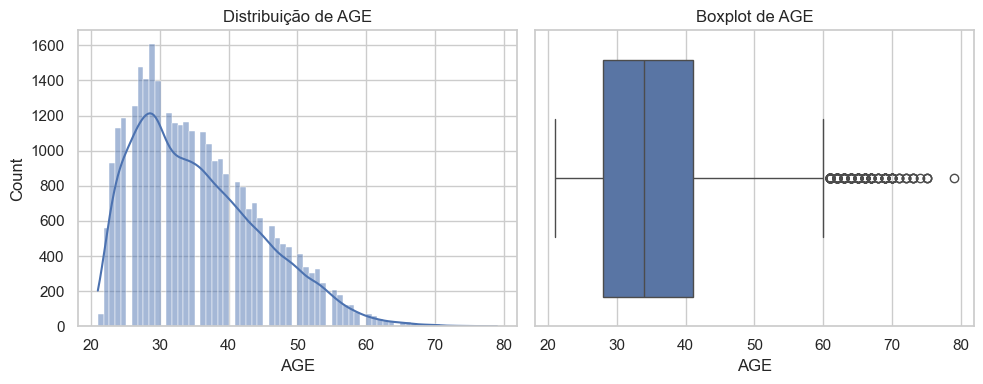

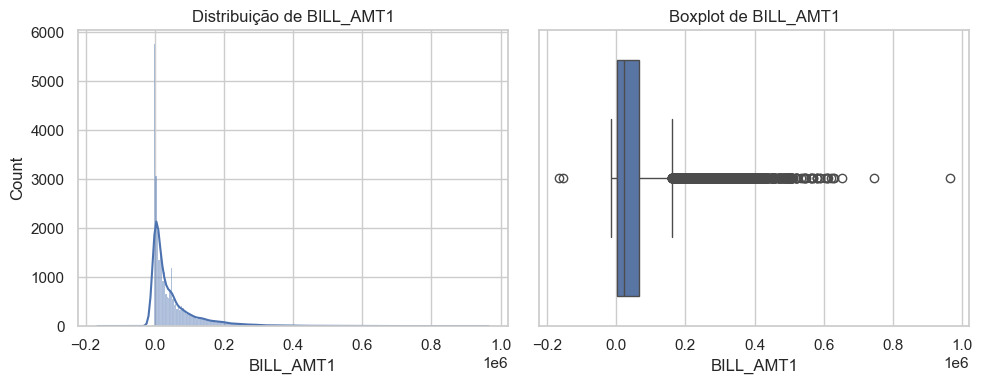

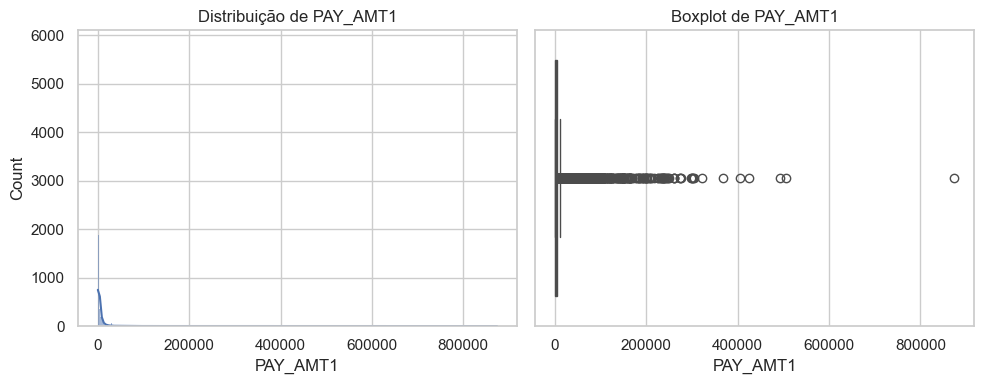

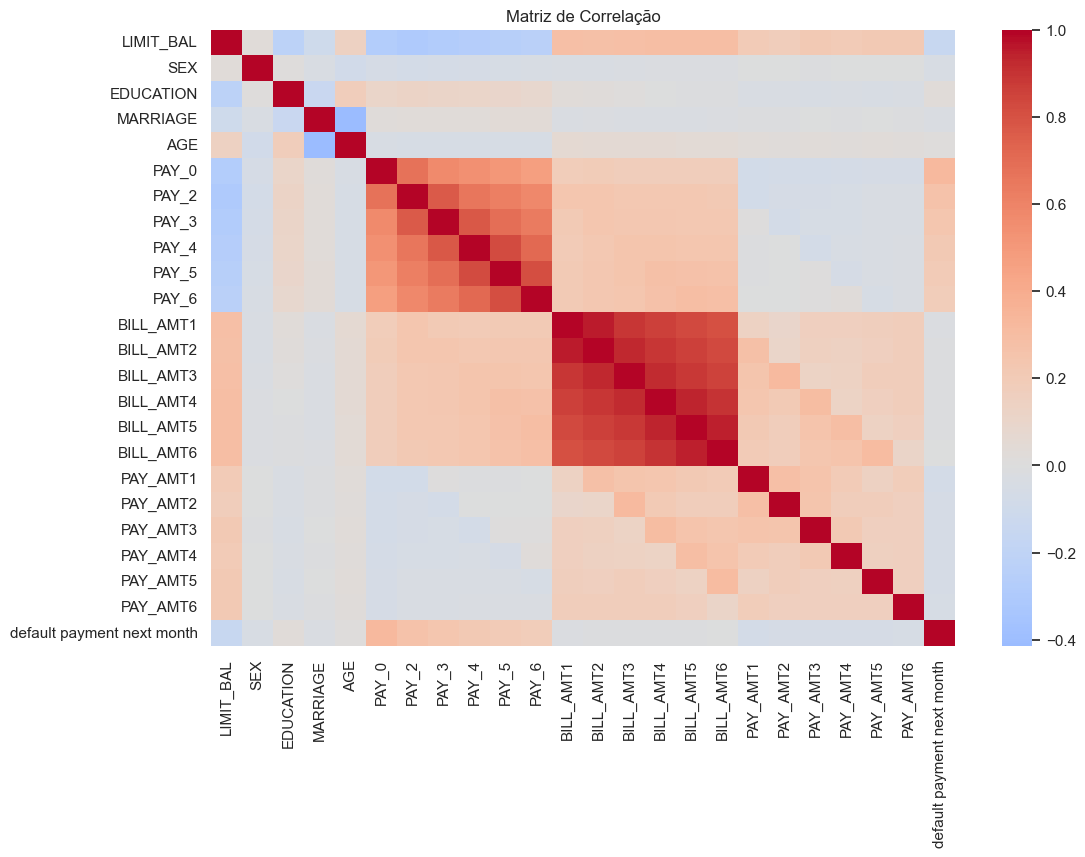

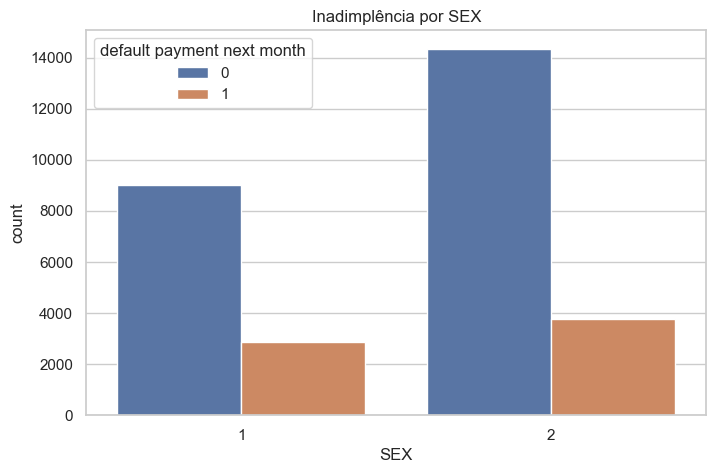

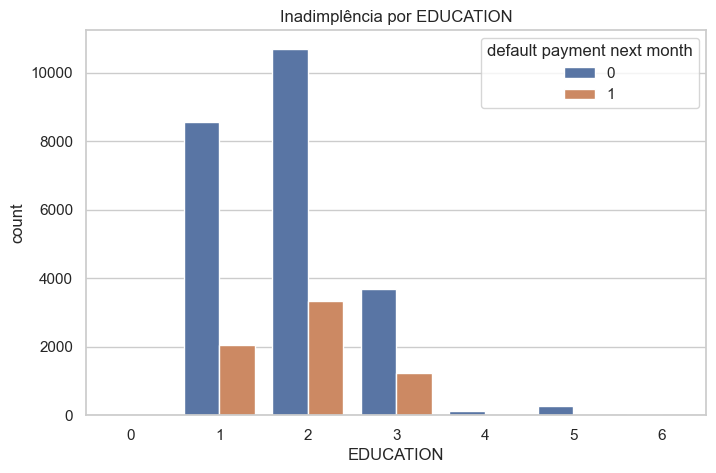

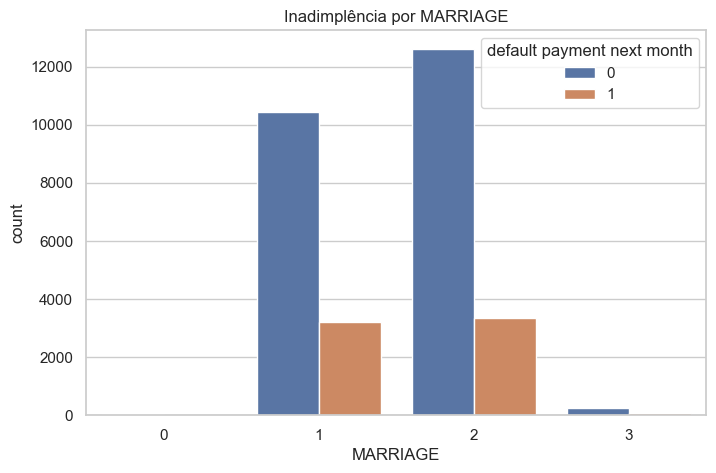

In [3]:
plt.figure(figsize=(8, 5))
sns.countplot(x="default payment next month", data=df)
plt.title("Distribuição da Inadimplência")
plt.xlabel("Default (Inadimplência)")
plt.ylabel("Contagem")
plt.show()

num_cols = ["LIMIT_BAL", "AGE", "BILL_AMT1", "PAY_AMT1"]
for col in num_cols:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribuição de {col}")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Matriz de Correlação")
plt.show()

cat_cols = ["SEX", "EDUCATION", "MARRIAGE"]
for col in cat_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, hue="default payment next month", data=df)
    plt.title(f"Inadimplência por {col}")
    plt.show()

In [4]:
print("Valores faltantes antes do tratamento:")
print(df.isnull().sum())

def treat_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df



for col in ["LIMIT_BAL", "BILL_AMT1", "PAY_AMT1"]:
    df = treat_outliers(df, col)

X = df.drop("default payment next month", axis=1)
y = df["default payment next month"]

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Valores faltantes antes do tratamento:
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64



Regressão Logística - Métricas:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      7005
           1       0.72      0.73      0.72      7014

    accuracy                           0.72     14019
   macro avg       0.72      0.72      0.72     14019
weighted avg       0.72      0.72      0.72     14019



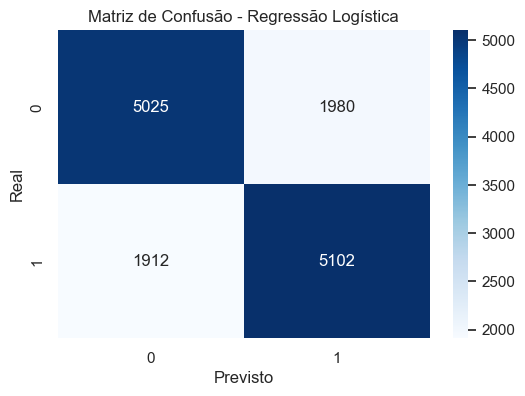

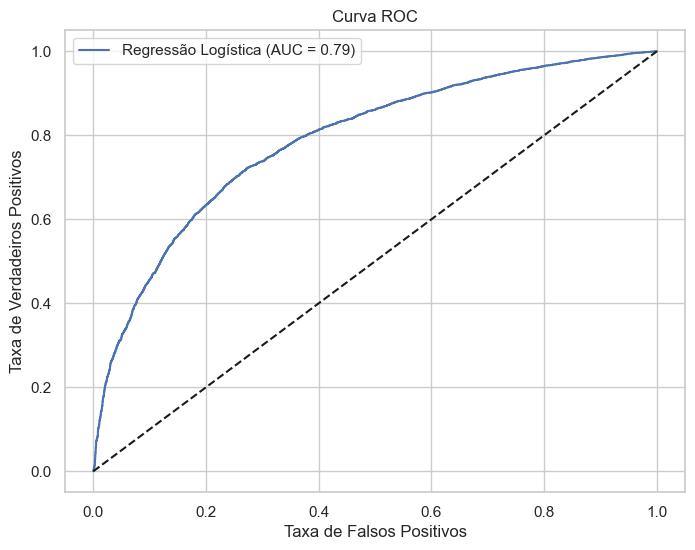

In [5]:

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)
y_pred_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nRegressão Logística - Métricas:")
print(classification_report(y_test, y_pred_log))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Regressão Logística")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_log)
plt.figure(figsize=(8, 6))
plt.plot(
    fpr,
    tpr,
    label=f"Regressão Logística (AUC = {roc_auc_score(y_test, y_pred_proba_log):.2f})",
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()


Random Forest - Métricas:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      7005
           1       0.85      0.81      0.83      7014

    accuracy                           0.84     14019
   macro avg       0.84      0.84      0.84     14019
weighted avg       0.84      0.84      0.84     14019



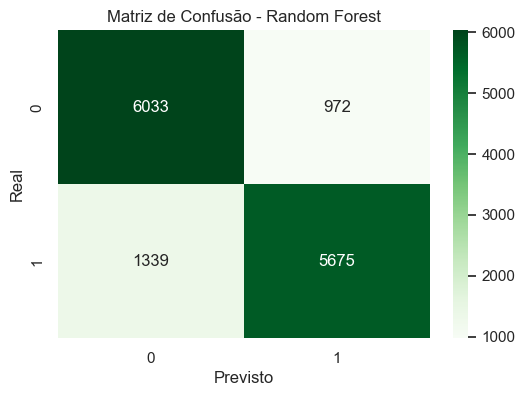

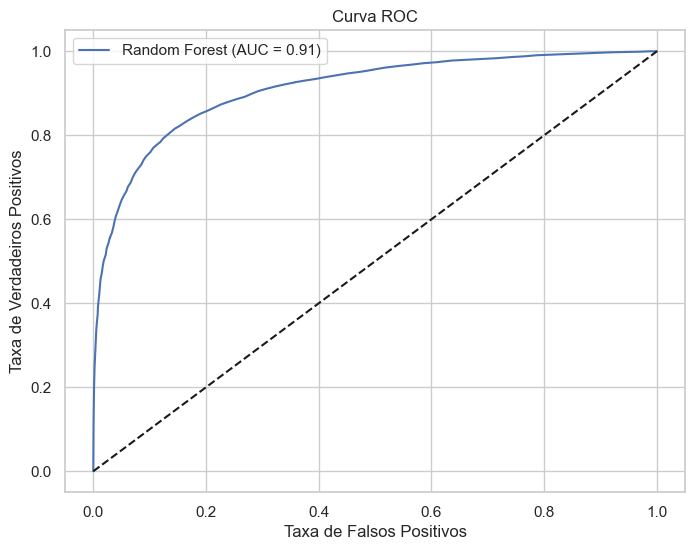

In [6]:

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)  

y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest - Métricas:")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(
    fpr_rf,
    tpr_rf,
    label=f"Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.2f})",
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Melhores parâmetros encontrados:
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest Otimizado - Métricas:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      7005
           1       0.85      0.81      0.83      7014

    accuracy                           0.84     14019
   macro avg       0.84      0.84      0.84     14019
weighted avg       0.84      0.84      0.84     14019



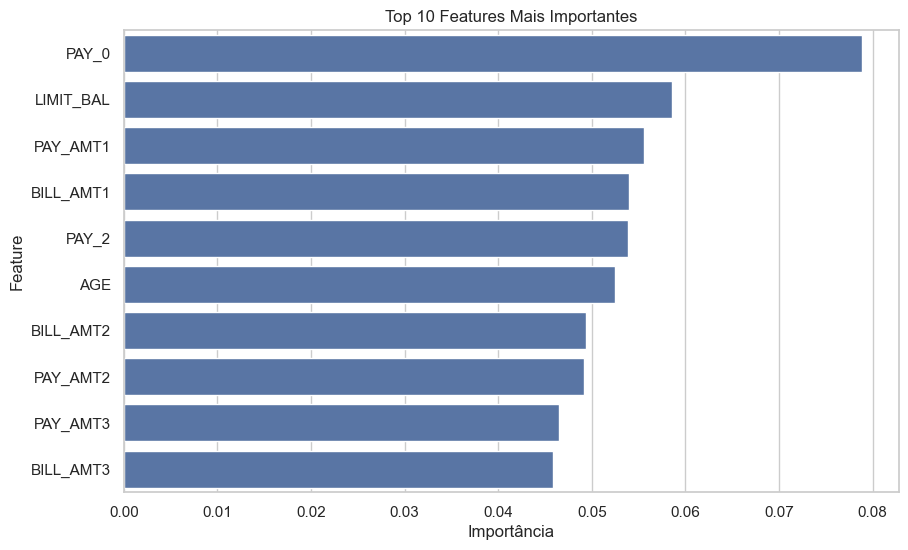

In [7]:

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="roc_auc",
)

grid_search.fit(X_train, y_train)

print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
y_pred_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Otimizado - Métricas:")
print(classification_report(y_test, y_pred_best_rf))

feature_importances = pd.DataFrame(
    best_rf.feature_importances_, index=X.columns, columns=["importance"]
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance[:10], y=feature_importances.index[:10])
plt.title("Top 10 Features Mais Importantes")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()


Comparação dos Modelos:
                         Acurácia  Precisão    Recall  F1-Score   AUC-ROC
Modelo                                                                   
Regressão Logística      0.722377  0.720418  0.727402  0.723893  0.788598
Random Forest            0.835152  0.853769  0.809096  0.830832  0.909757
Random Forest Otimizado  0.836579  0.852937  0.813658  0.832835  0.913142


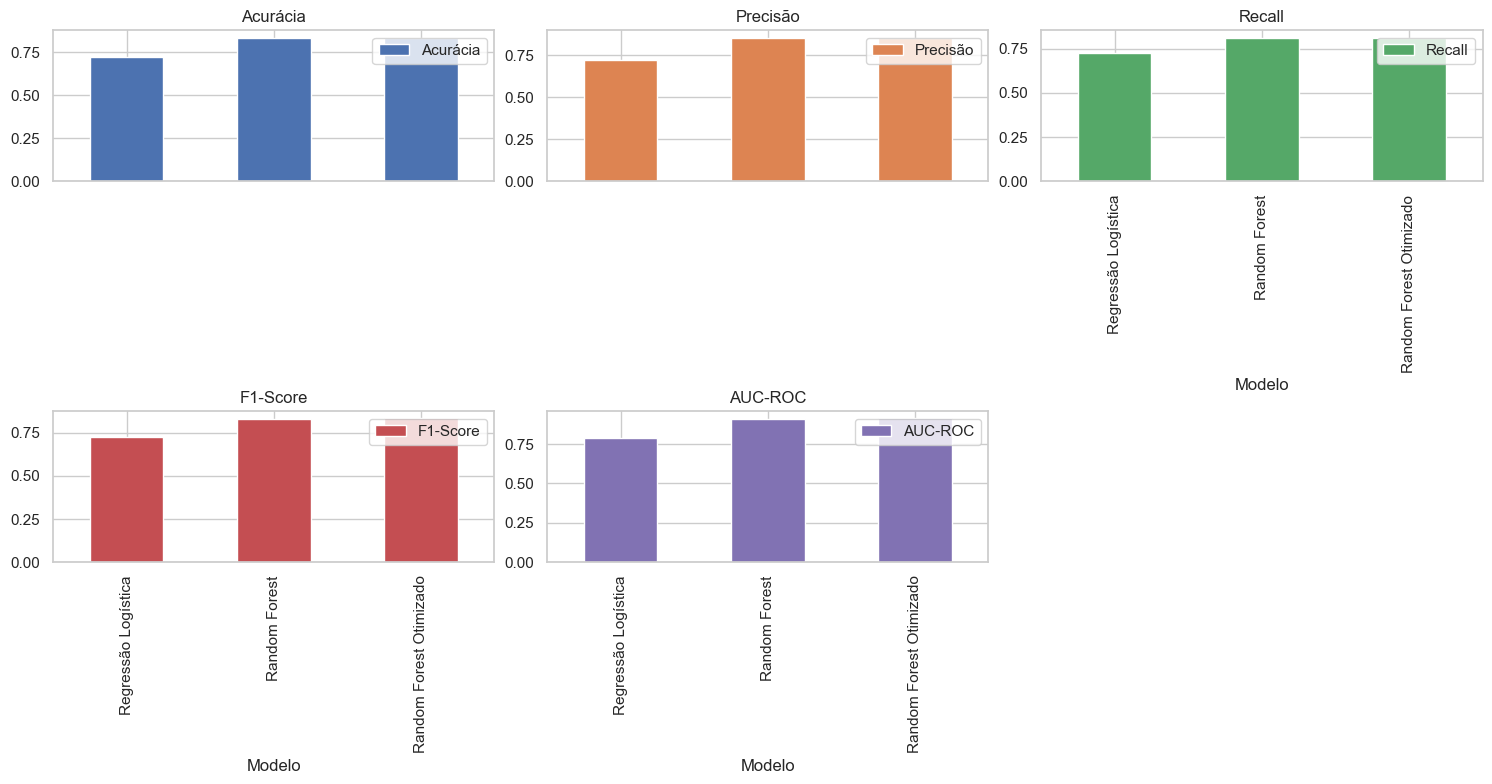

In [8]:

models = {
    "Regressão Logística": {"model": log_reg, "scaled": True},
    "Random Forest": {"model": rf, "scaled": False},
    "Random Forest Otimizado": {"model": best_rf, "scaled": False},
}

results = []
for name, config in models.items():
    if config["scaled"]:
        X_eval = X_test_scaled
    else:
        X_eval = X_test

    model = config["model"]
    y_pred = model.predict(X_eval)
    y_proba = model.predict_proba(X_eval)[:, 1]

    results.append(
        {
            "Modelo": name,
            "Acurácia": accuracy_score(y_test, y_pred),
            "Precisão": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "AUC-ROC": roc_auc_score(y_test, y_proba),
        }
    )

results_df = pd.DataFrame(results).set_index("Modelo")
print("\nComparação dos Modelos:")
print(results_df)


results_df.plot(kind="bar", subplots=True, layout=(2, 3), figsize=(15, 8))
plt.tight_layout()
plt.show()

In [9]:
os.makedirs(os.path.join('..', 'models'), exist_ok=True)

joblib.dump(best_rf, "../models/modelo_002.pkl")
print("Modelo salvo com sucesso em '/models/modelo_002.pkl'")

Modelo salvo com sucesso em '/models/modelo_002.pkl'
